<a href="https://colab.research.google.com/github/cosmo-001/Hierarchical-Time-Series-Modelling-BU-/blob/main/bottomUp_HINT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Forecast Networks

## 1. Installing packages

In [ ]:
%%capture
!pip install datasetsforecast hierarchicalforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install neuralforecast

## 2. Load hierarchical dataset

In [ ]:
import pandas as pd

# Load data from CSV file
df = pd.read_csv('/content/time series data/time_series.csv', index_col='STORE_ID')
df.dropna(inplace=True)

# Reset the index to make STORE_ID a column
df.reset_index(inplace=True)
df = df.drop(df[df['STORE_ID'] >= 10200].index)

# Melt the DataFrame to create the desired structure
Y_df = pd.melt(df, id_vars=['STORE_ID'], var_name='ds', value_name='y')

# Convert 'ds' column to datetime format
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# Rename 'STORE_ID' column to 'unique_id'
Y_df.rename(columns={'STORE_ID': 'unique_id'}, inplace=True)


# Append a row for total sales for each store
total_sales = Y_df.groupby('ds')['y'].sum().reset_index()

total_sales['unique_id'] = 'TotalAll'

# Create a DataFrame with only "TotalAll" rows
total_all_df = total_sales[['unique_id', 'ds', 'y']]

# Create a DataFrame with individual store sales
individual_sales_df = Y_df.drop(total_sales.index)

# Concatenate "TotalAll" DataFrame on top of individual store sales DataFrame
Y_df = pd.concat([total_all_df, individual_sales_df], ignore_index=True)
Y_df = Y_df.sort_values(by=["unique_id", "ds"], ascending=True)

print(Y_df)

     unique_id         ds       y
1476     10001 2016-01-05    1374
1640     10001 2016-01-06    1270
1804     10001 2016-01-07    1123
1968     10001 2016-01-08    1259
2132     10001 2016-01-09    1225
...        ...        ...     ...
1458  TotalAll 2019-12-24  317328
1459  TotalAll 2019-12-25    6963
1460  TotalAll 2019-12-26   46496
1461  TotalAll 2019-12-27  130242
1462  TotalAll 2019-12-28   98798

[239932 rows x 3 columns]


In [ ]:

unique_ids_count = Y_df['unique_id'].nunique()

print(f"Number of unique IDs: {unique_ids_count}")



Number of unique IDs: 165


In [ ]:
import numpy as np


# Number of stores = n

n = 164

summing_matrix_for_sales = np.zeros((165,164))

summing_matrix_for_sales[0,0:] = 1
for i in range(n):
  summing_matrix_for_sales[i+1,i] = 1


print(summing_matrix_for_sales)



[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


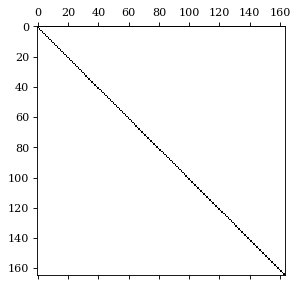

In [ ]:
import matplotlib.pyplot as plt
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

tags = {
    'TotalAll': ['TotalAll'],  # Represents the total daily sales
    'Store': list(Y_df['unique_id'].unique())
}

hplot = HierarchicalPlot(S=summing_matrix_for_sales, tags=tags)
hplot.plot_summing_matrix()


## 3. Fit and Predict HINT


In [ ]:
import numpy as np

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS, HINT
from neuralforecast.losses.pytorch import GMM, PMM, DistributionLoss, sCRPS

In [ ]:
# Train test splits
horizon = 70
Y_test_df = Y_df.groupby('unique_id').tail(70)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')


In [ ]:
print(Y_train_df)

                  ds       y
unique_id                   
10001     2016-01-05    1374
10001     2016-01-06    1270
10001     2016-01-07    1123
10001     2016-01-08    1259
10001     2016-01-09    1225
...              ...     ...
TotalAll  2019-10-15  110005
TotalAll  2019-10-16  112382
TotalAll  2019-10-17  112324
TotalAll  2019-10-18  142153
TotalAll  2019-10-19  146634

[228382 rows x 2 columns]


In [ ]:
Y_train_df.index = Y_train_df.index.astype(str)

In [ ]:

# Horizon and quantiles
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] if lv!=0 else [50] for lv in level]
quantiles = np.sort(np.concatenate(qs) / 100)

# HINT := BaseNetwork + Distribution + Reconciliation
nhits = NHITS(
              h=horizon,
              input_size=36,
              loss=GMM(n_components=10, quantiles=quantiles),
              #hist_exog_list=['month'],
              max_steps=2000,
              early_stop_patience_steps=10,
              val_check_steps=50,
              scaler_type='robust',
              learning_rate=5e-4,
              valid_loss=sCRPS(quantiles=quantiles),
              )


model = HINT(h=horizon, S=summing_matrix_for_sales, model=nhits, reconciliation='BottomUp')











INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
%%capture
Y_df['y'] = Y_df['y'] * (Y_df['y'] > 0)
nf = NeuralForecast(models=[model], freq='D')
#Y_hat_df = nf.cross_validation(df=df_aggregated, val_size=12, n_windows=1)
nf.fit(df=Y_train_df, val_size=70)



In [ ]:
Y_hat_df = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

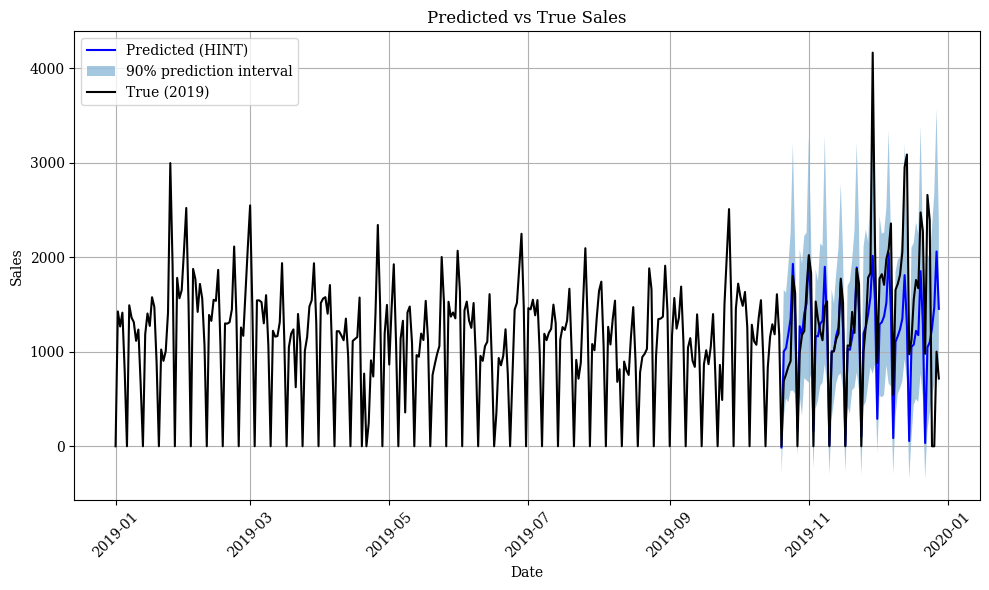

In [ ]:
import matplotlib.pyplot as plt

Y_hat_df = Y_hat_df.reset_index()


plot_df = Y_hat_df[(Y_hat_df['unique_id'] == '10006')]

# Filter the true data for the same unique_id and date range
true_df = Y_df[(Y_df['unique_id'] == 10006) & (Y_df['ds'].dt.year == 2019)]

plt.figure(figsize=(10, 6))

# Plot predicted values (HINT)
plt.plot(plot_df['ds'], plot_df['HINT'], c='blue', label='Predicted (HINT)')
plt.fill_between(x=plot_df['ds'],
                 y1=plot_df['HINT-lo-90.0'].values,
                 y2=plot_df['HINT-hi-90.0'].values,
                 alpha=0.4, label='90% prediction interval')

# Plot true values
plt.plot(true_df['ds'], true_df['y'], c='black', label='True (2019)')

plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Predicted vs True Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


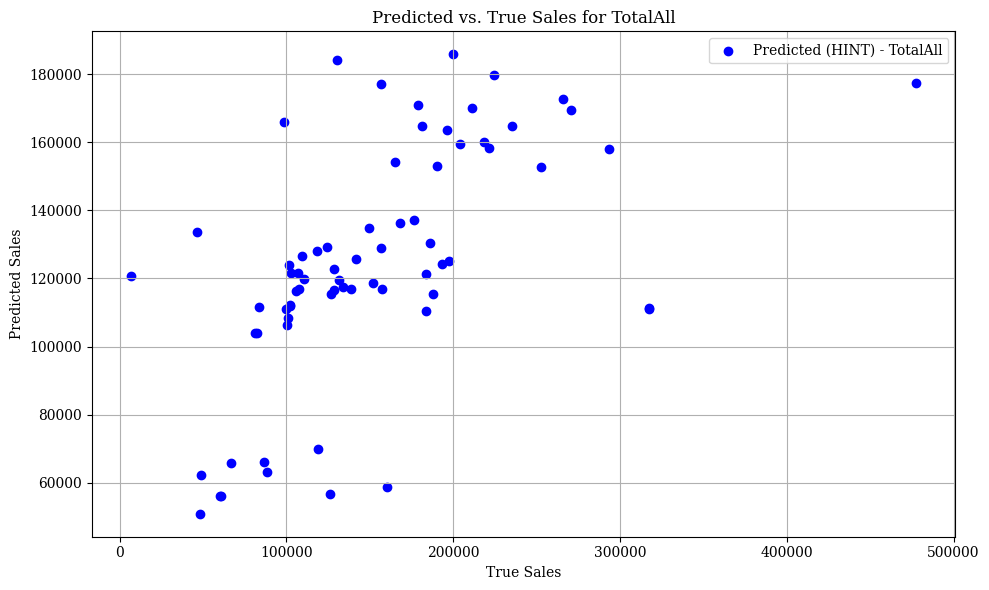

In [ ]:
import matplotlib.pyplot as plt

unique_id_total_all = "TotalAll"

# Filter the true data for 'TotalAll' and the same date range
true_df_total_all = Y_df[(Y_df['unique_id'] == unique_id_total_all) & (Y_df['ds'].isin(Y_hat_df['ds']))]

# Filter the predicted data for 'TotalAll'
plot_df_total_all = Y_hat_df[Y_hat_df['unique_id'] == unique_id_total_all]

plt.figure(figsize=(10, 6))

# Plot predicted values (HINT) for TotalAll
plt.scatter(true_df_total_all['y'], plot_df_total_all['HINT'], c='blue', label='Predicted (HINT) - TotalAll')

plt.legend()
plt.grid()
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Predicted vs. True Sales for {unique_id_total_all}')
plt.tight_layout()
plt.show()


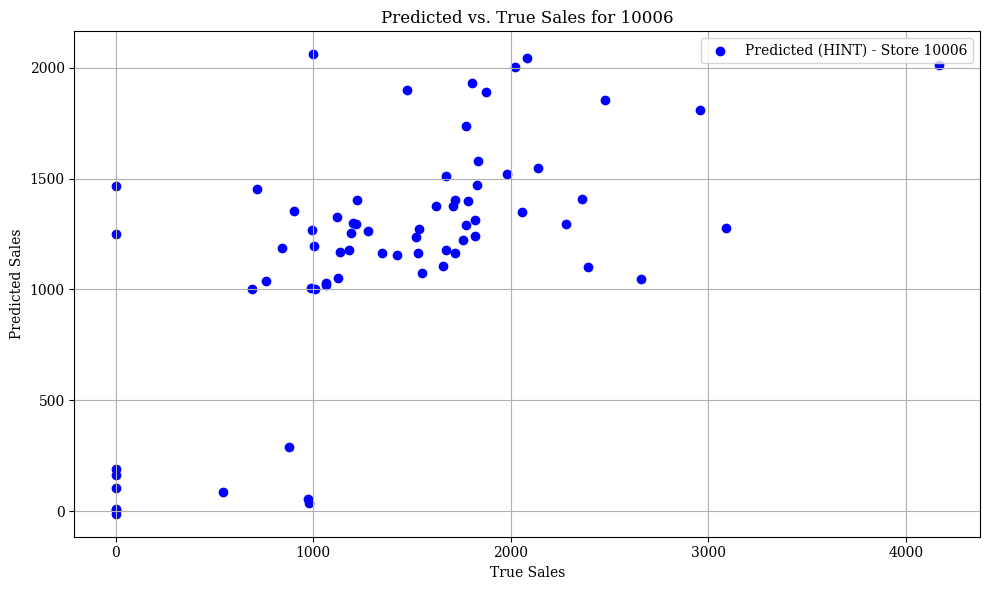

In [ ]:
import matplotlib.pyplot as plt

true_df_total_all = Y_df[(Y_df['unique_id'] == 10006) & (Y_df['ds'].isin(Y_hat_df['ds']))]

# Filter the predicted data for Store 10006
plot_df_total_all = Y_hat_df[Y_hat_df['unique_id'] == '10006']

plt.figure(figsize=(10, 6))

# Plot predicted values (HINT) for Store 10006
plt.scatter(true_df_total_all['y'], plot_df_total_all['HINT'], c='blue', label='Predicted (HINT) - Store 10006')

plt.legend()
plt.grid()
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Predicted vs. True Sales for {10006}')
plt.tight_layout()
plt.show()


In [ ]:
print(Y_hat_df)

      unique_id         ds           HINT   HINT-lo-98.0   HINT-lo-96.0  \
0         10001 2019-10-20  102415.381187   56714.375891   66399.013802   
1         10001 2019-10-21  204936.787318  133370.004328  144022.540412   
2         10001 2019-10-22  207927.140649  143836.703144  153167.008985   
3         10001 2019-10-23  225025.885937  151915.278913  166044.844148   
4         10001 2019-10-24  248250.984880  167681.971256  183798.927005   
...         ...        ...            ...            ...            ...   
11545  TotalAll 2019-12-24  111122.094530    9674.353516   27491.655184   
11546  TotalAll 2019-12-25  120700.349782   44948.991457   53999.235796   
11547  TotalAll 2019-12-26  133694.543127   52749.940325   56262.976562   
11548  TotalAll 2019-12-27  184292.836452   65466.175781   72902.671875   
11549  TotalAll 2019-12-28  166116.613551   20632.662268   67469.867188   

        HINT-lo-94.0   HINT-lo-92.0   HINT-lo-90.0   HINT-lo-88.0  \
0       68781.444299   71624.7

## 4. Forecast Evaluation

In [ ]:
#This code defines a function to calculate sCRPS for different
#hierarchical levels of forecasting by comparing observed values
#to probabilistic forecasts for each level. It does this by using a list
#of indexes that specify which data points belong to each level of the hierarchy.
matrix = pd.DataFrame(summing_matrix_for_sales)

from hierarchicalforecast.evaluation import scaled_crps

def _get_hierarchical_scrps(hier_idxs, Y, Yq_hat, quantiles):
    # We use the indexes obtained from the aggregation tags
    # to compute scaled CRPS across the hierarchy levels
    scrps_list = []
    for idxs in hier_idxs:
        y      = Y[idxs, :]
        yq_hat = Yq_hat[idxs, :, :]
        scrps  = scaled_crps(y, yq_hat, quantiles)
        scrps_list.append(scrps)
    return scrps_list

# Define the hierarchical structure
tags = {
    'TotalAll': ['TotalAll'],  # Represents the total daily sales
    'Store': list(Y_df['unique_id'].unique())
}
hier_idxs = [np.arange(len(matrix))] +\
    [matrix.index.get_indexer(tags[level]) for level in list(tags.keys())]


In [ ]:
#This code performs bootstrapping to generate multiple sets
#of quantile predictions for a model, which can be useful for
#estimating prediction uncertainty and calculating performance
#metrics across different samples.

%%capture
n_series = len(summing_matrix_for_sales)
n_quantiles = len(quantiles)

# Bootstrap predictions
n_samples = 5
Y_hat_df_list = [nf.predict() for _ in range(n_samples)]

# Parse y_test and y_rec
# Keep only quantile columns from Y_hat_df
# Removing mean and median default outputs
model_name = type(model).__name__
quantile_columns = [model_name + n for n in nhits.loss.output_names]
quantile_columns.remove(model_name)
Yq_hat = []
for sample_idx in range(n_samples):
    Y_hat = Y_hat_df_list[sample_idx][quantile_columns].values
    Yq_hat.append(Y_hat.reshape(1, n_series, horizon, n_quantiles))

Yq_hat = np.concatenate(Yq_hat, axis=0)
Y_test = Y_test_df['y'].values.reshape(n_series, horizon)

In [ ]:
print('Y_test.shape [n_series, horizon]', Y_test.shape)
print('Yq_hat.shape [n_samples, n_series, horizon, n_quantiles]', Yq_hat.shape)
print(sample_idx)


Y_test.shape [n_series, horizon] (165, 70)
Yq_hat.shape [n_samples, n_series, horizon, n_quantiles] (5, 165, 70, 99)
4


In [ ]:
# Compute bootstraped sCRPS
scrps_hint = [_get_hierarchical_scrps(hier_idxs, Y_test, Yq_hat[sample_idx], quantiles) \
              for sample_idx in range(n_samples)]
crps_mean = np.mean(np.array(scrps_hint), axis=0)
crps_std = np.std(np.array(scrps_hint), axis=0)
scrps_hint = [f'{crps_mean[level_idx]:.4f}±{(1.96 * crps_std[level_idx]):.4f}' \
              for level_idx in range(len(crps_mean))]

In [ ]:
print(scrps_hint)


['0.9942±0.0009', '0.2290±0.0026', '0.2290±0.0026']


In [ ]:
import math
from sklearn.metrics import mean_squared_error

Y_test_df = Y_test_df.reset_index()
# Predicted values from Y_hat_df
predicted = Y_hat_df['HINT'].values

# True values from Y_test_df
true = Y_test_df['y'].values

# Define hierarchy levels
hier_levels = ['TotalAll', 'Store Level']

for level_name in hier_levels:
    # Filter predicted and true values for the current level
    if level_name == 'TotalAll':
        level_idxs = (Y_test_df['unique_id'] == 'TotalAll')
    else:
        level_idxs = (Y_test_df['unique_id'] != 'TotalAll')

    subset_predicted = predicted[level_idxs]
    subset_true = true[level_idxs]

    # Calculate RMSE using sklearn for the current level
    mse = mean_squared_error(subset_true, subset_predicted)
    rmse = math.sqrt(mse)

    if np.isnan(rmse):
        print(f'RMSE for {level_name} resulted in NaN')
    else:
        print(f'RMSE for {level_name}: {rmse:.4f}')



RMSE for TotalAll: 68624.8580
RMSE for Store Level: 19967.3979


In [ ]:
# Predicted values from Y_hat_df
predicted = Y_hat_df['HINT'].values

# True values from Y_test_df
true = Y_test_df['y'].values

# Define hierarchy levels
hier_levels = ['TotalAll', 'Store Level']

for level_name in hier_levels:
    # Filter predicted and true values for the current level
    if level_name == 'TotalAll':
        level_idxs = (Y_test_df['unique_id'] == 'TotalAll')
    else:
        level_idxs = (Y_test_df['unique_id'] != 'TotalAll')

    subset_predicted = predicted[level_idxs]
    subset_true = true[level_idxs]

    # Calculate MAE using sklearn for the current level
    mae = np.mean(np.abs(subset_true - subset_predicted))

    if np.isnan(mae):
        print(f'MAE for {level_name} resulted in NaN')
    else:
        print(f'MAE for {level_name}: {mae:.4f}')




MAE for TotalAll: 44838.7091
MAE for Store Level: 1818.3529
